# Image Recognition to Identify Species of Flowers

#### Import all necessary libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import random

from tensorflow.keras.utils import get_file
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2
import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image

# model selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

#### Preparing the Data

In [ ]:
# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# filename = os.path.join(os.getcwd(), 'flower_photos.zip')
# #print(filename)
# get_file(os.path.basename(dataset_url), dataset_url, cache_dir=os.getcwd())

In [4]:
# Downloading a file from a URL if it is not already in the cache
dataset_url = "http://download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')
print(data_dir)

C:\Users\AsusIran\.keras\datasets\flower_photos


In [5]:
# get all path of directories

#directories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
directories = [os.path.join(data_dir, d) for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
print(directories)

['C:\\Users\\AsusIran\\.keras\\datasets\\flower_photos\\daisy', 'C:\\Users\\AsusIran\\.keras\\datasets\\flower_photos\\dandelion', 'C:\\Users\\AsusIran\\.keras\\datasets\\flower_photos\\roses', 'C:\\Users\\AsusIran\\.keras\\datasets\\flower_photos\\sunflowers', 'C:\\Users\\AsusIran\\.keras\\datasets\\flower_photos\\tulips']


In [6]:
# add data of various dir in one list and labels in another list

img_list = []
label_list = []

img_height = 180
img_width = 180

def make_train_data(flower_type, DIR):
    counter = 0
    for img in os.listdir(DIR):
        label = assign_label(img, flower_type)
        path = os.path.join(DIR, img)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (img_width, img_height))
        
        img_list.append(np.array(img))
        label_list.append(str(label))
        counter += 1
    print(f"Type name: {flower_type}, Count: {counter}")

def assign_label(img, flower_type):
    return flower_type

for path in directories:
    name = path.split('\\')
    flower_type = name[len(name) -1]
    # print(path)    
    make_train_data(flower_type, path)

print(f"Dataset count: {len(img_list)}")

Type name: daisy, Count: 633
Type name: dandelion, Count: 898
Type name: roses, Count: 641
Type name: sunflowers, Count: 699
Type name: tulips, Count: 799
Dataset count: 3670


#### Split data to train and test categories

In [93]:
x_train, x_test, y_train, y_test = train_test_split(img_list, label_list, test_size = 0.2, random_state = 42)
#print(y_train)
#print(type(x_train))

In [94]:
# convert sets to array

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(x_train.shape)

(2936, 180, 180, 3)


#### Scale the data to become in the same range

In [ ]:
#x_train = x_train.reshape(-1, x_train.shape[-1])
#x_test = x_test.reshape(-1 , x_test.shape[-1])

#scale = MinMaxScaler()
#scale.fit(x_train)
#x_train_scaled = scale.transform(x_train)
#x_test_scaled = scale.transform(x_test)

#### Visualization with random train data

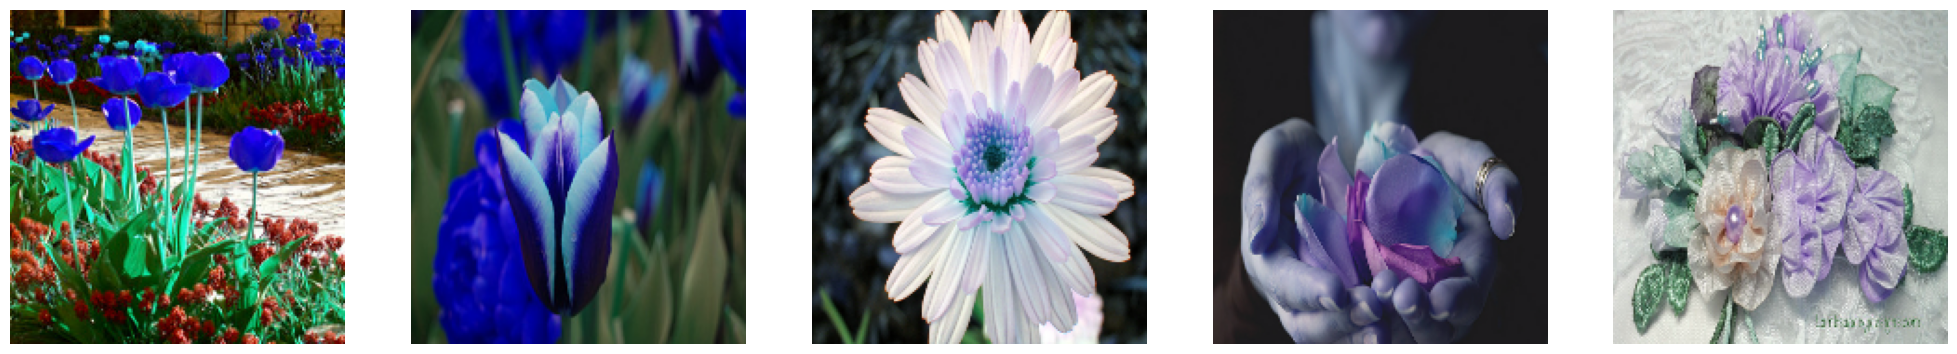

In [16]:
# create a subplot with 1 row and 5 columns
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (25, 5))

for i in range(5):
    random_index = random.randint(0, len(x_train)) # create a random num to use as an index
    ax[i].imshow(x_train[random_index])
    ax[i].axis('off')
    
plt.show()

#### Convert categorical data to encoded one by applying 'LabelEncoder' and 'One Hot Encoding' to the y array

In [95]:
#create an instance
label_encoder = LabelEncoder()
y_train_cat = label_encoder.fit_transform(y_train)
y_train_cat = to_categorical(y_train_cat, 5)

y_test_cat = label_encoder.fit_transform(y_test)
y_test_cat = to_categorical(y_test_cat, 5)

print(f"Original labels : \n {y_train[:5]}", end='\n')
print(f"One hot encoded labels : \n {y_train_cat[:5]}")

Original labels : 
 ['dandelion' 'sunflowers' 'dandelion' 'tulips' 'daisy']
One hot encoded labels : 
 [[0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]


In [48]:
# normalise the input image arrays so that the pixel values are between 0 and 1

print(f'Minimum pixel: {min(x_train[0].flatten())}') # prints the minimum pixel 
print(f'Maximum pixel: {max(x_train[0].flatten())}') # prints the maximum pixel

print(f'Datatype: {np.array(x_train).dtype}') # The datatype is unsigned integer hence the need to convert tc

# normalisation
x_train = np.array(x_train) / 245
x_test = np.array(x_test) / 245

Minimum pixel: 0
Maximum pixel: 245
Datatype: uint8


In [49]:
print(f"The shape is : {x_train.shape}")

The shape is : (2936, 180, 180, 3)


In [50]:
# define the image transformations for data augmentation
train_datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    vertical_flip = False,
    shear_range = 0.10,
    zoom_range = 0.10,
    validation_split = 0.2
)

Text(0.5, 0, 'Agumented image')

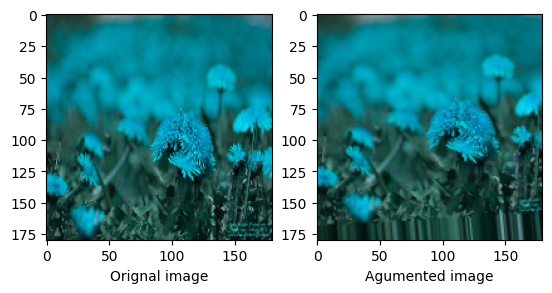

In [23]:
#plotting an original image and augumented image 

train_datagen.fit(x_train) # fitting the training image 
new_image = train_datagen.random_transform(x_train[0]) # augumented image

fig, ax = plt.subplots(nrows = 1, ncols = 2)
ax[0].imshow(x_train[0])
ax[1].imshow(new_image)
ax[0].set_xlabel ('Orignal image')
ax[1].set_xlabel ('Agumented image')

In [79]:
# CNN Model

width_npix = 180
height_npix = 180

model = Sequential()

# 1st layer
model.add(Conv2D(filters = 32, kernel_size = (3, 3), input_shape = (width_npix, height_npix, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd layer
model.add(Conv2D(filters = 64, kernel_size = (3, 3), input_shape = (width_npix, height_npix, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

# 3rd layer
model.add(Conv2D(filters = 128, kernel_size = (3, 3), input_shape = (width_npix, height_npix, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

# Flatten layer
model.add(Flatten())

# Dense layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# output layer
model.add(Dense(5, activation = 'softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 20, 20, 128)     

In [80]:
# compile the model

adam = Adam(learning_rate = 0.01)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [81]:
# train the model

batch_size = 32
history = model.fit(
    train_datagen.flow(x_train, y_train_cat, batch_size = batch_size, subset = 'training'), 
    epochs = 20, 
    validation_data = train_datagen.flow(x_train, y_train_cat, batch_size = batch_size, subset = 'validation'))

Epoch 1/20
74/74 [==============================] - 29s 386ms/step - loss: 2.0526 - accuracy: 0.2797 - val_loss: 1.5953 - val_accuracy: 0.2658
Epoch 2/20
74/74 [==============================] - 29s 391ms/step - loss: 1.6015 - accuracy: 0.2452 - val_loss: 1.5946 - val_accuracy: 0.2658
Epoch 3/20
74/74 [==============================] - 29s 389ms/step - loss: 1.6003 - accuracy: 0.2452 - val_loss: 1.5952 - val_accuracy: 0.2658
Epoch 4/20
74/74 [==============================] - 29s 386ms/step - loss: 1.5998 - accuracy: 0.2452 - val_loss: 1.5939 - val_accuracy: 0.2658
Epoch 5/20
74/74 [==============================] - 29s 387ms/step - loss: 1.6000 - accuracy: 0.2452 - val_loss: 1.5941 - val_accuracy: 0.2658
Epoch 6/20
74/74 [==============================] - 28s 382ms/step - loss: 1.5994 - accuracy: 0.2452 - val_loss: 1.5938 - val_accuracy: 0.2658
Epoch 7/20
74/74 [==============================] - 29s 384ms/step - loss: 1.5994 - accuracy: 0.2452 - val_loss: 1.5944 - val_accuracy: 0.2658

In [103]:
# Plotting the history of the training and evaluation on the validation set

df_history = pd.DataFrame(history.history)
df_history

,loss,accuracy,val_loss,val_accuracy
0,2.052639,0.279693,1.595287,0.265758
1,1.601503,0.245211,1.594622,0.265758
2,1.600267,0.245211,1.595189,0.265758
3,1.599823,0.245211,1.593916,0.265758
4,1.600022,0.245211,1.594070,0.265758
5,1.599426,0.245211,1.593805,0.265758
6,1.599413,0.245211,1.594432,0.265758
7,1.599574,0.245211,1.593156,0.265758
8,1.600133,0.245211,1.593668,0.265758
9,1.599761,0.245211,1.595627,0.265758


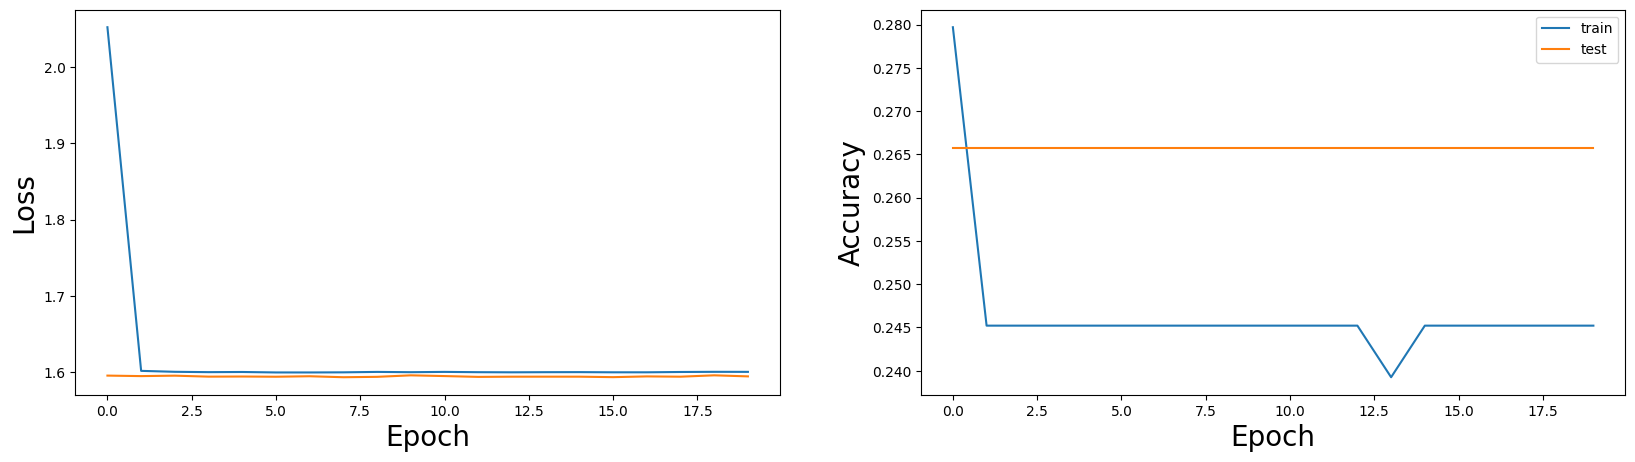

In [104]:
training_loss = df_history['loss']
val_loss = df_history['val_loss']

training_accuracy = df_history['accuracy']
val_accuracy = df_history['val_accuracy']

# plot of the loss
fig, ax = plt.subplots(1, 2, figsize = (20, 5)) # create two axes (0, 1)
ax[0].plot(training_loss)
ax[0].plot(val_loss)
ax[0].set_xlabel('Epoch', fontsize = 20)
ax[0].set_ylabel('Loss', fontsize = 20)
plt.legend(['train', 'test'])

# plot of the accuracy
ax[1].plot(training_accuracy)
ax[1].plot(val_accuracy)
ax[1].set_xlabel('Epoch', fontsize = 20)
ax[1].set_ylabel('Accuracy', fontsize = 20)
plt.legend(['train', 'test'])

In [105]:
# evaluation

model.evaluate(x = x_test, y = y_test_cat)

23/23 [==============================] - 2s 70ms/step - loss: 1.8668 - accuracy: 0.2752


[1.866847276687622, 0.2752043604850769]

In [111]:
# evaluation on the test set
y_pred = model.predict(x_test)
print(y_pred[:10])
y_pred_class = np.argmax(y_pred, axis=1)

23/23 [==============================] - 2s 70ms/step
[[0.03604028 0.16676104 0.18329112 0.02182339 0.59208417]
 [0.16509448 0.2432635  0.1791257  0.19460396 0.2179124 ]
 [0.09361836 0.2753163  0.19163108 0.08440789 0.35502633]
 [0.10722541 0.27619883 0.19987369 0.09309257 0.32360944]
 [0.16509448 0.2432635  0.1791257  0.19460396 0.2179124 ]
 [0.10079113 0.2801928  0.17839144 0.12544861 0.315176  ]
 [0.05190064 0.29039124 0.14306234 0.07247157 0.4421742 ]
 [0.1619403  0.2558552  0.17674567 0.1930216  0.2124373 ]
 [0.11911366 0.29445383 0.19755976 0.10975599 0.27911678]
 [0.05388758 0.29384378 0.16032343 0.07105675 0.42088848]]


In [112]:
y_test_class = np.argmax(y_test)

In [113]:
label_encoder = LabelEncoder()
y_test_class = label_encoder.fit_transform(y_test)
#y_test_class = label_encoder.inverse_transform(y_test)

In [114]:
display_labels = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
numerical_labels = [i for i in range(5)]
print (display_labels)
print(numerical_labels)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
[0, 1, 2, 3, 4]


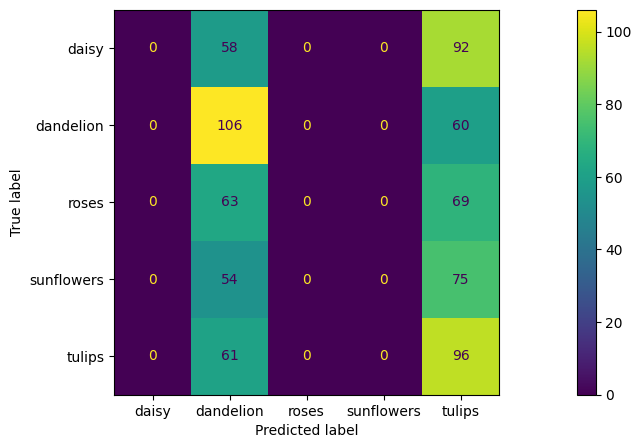

In [115]:
# Create the confusion matrix
con_mat = confusion_matrix(y_test_class, y_pred_class, labels = numerical_labels)
plt.figure(figsize = (20, 5))
ax = plt.axes()
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = con_mat, display_labels = display_labels)
disp.plot(ax = ax)
plt.show()

In [102]:
# Display the classification reportabs
print(classification_report(y_test_class, y_pred_class))

              precision    recall  f1-score   support

           0       0.82      0.77      0.80       150
           1       0.75      0.75      0.75       166
           2       0.67      0.48      0.56       132
           3       0.69      0.91      0.79       129
           4       0.67      0.69      0.68       157

    accuracy                           0.72       734
   macro avg       0.72      0.72      0.72       734
weighted avg       0.73      0.72      0.72       734



#  Hyperparameter Tuning

#### Change the Learning Rate to 0.001

In [24]:
# CNN Model

width_npix = 180
height_npix = 180

model = Sequential()

# 1st layer
model.add(Conv2D(filters = 32, kernel_size = (3, 3), input_shape = (width_npix, height_npix, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd layer
model.add(Conv2D(filters = 64, kernel_size = (3, 3), input_shape = (width_npix, height_npix, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

# 3rd layer
model.add(Conv2D(filters = 128, kernel_size = (3, 3), input_shape = (width_npix, height_npix, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

# Flatten layer
model.add(Flatten())

# Dense layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# output layer
model.add(Dense(5, activation = 'softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 128)      0

In [25]:
# compile the model

adam = Adam(learning_rate = 0.001)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [26]:
# train the model

batch_size = 32
history = model.fit(
    train_datagen.flow(x_train, y_train_cat, batch_size = batch_size, subset = 'training'), 
    epochs = 20, 
    validation_data = train_datagen.flow(x_train, y_train_cat, batch_size = batch_size, subset = 'validation'))

Epoch 1/20
74/74 [==============================] - 29s 385ms/step - loss: 1.4216 - accuracy: 0.3636 - val_loss: 1.2916 - val_accuracy: 0.4412
Epoch 2/20
74/74 [==============================] - 29s 393ms/step - loss: 1.2362 - accuracy: 0.4683 - val_loss: 1.2476 - val_accuracy: 0.4991
Epoch 3/20
74/74 [==============================] - 29s 388ms/step - loss: 1.1685 - accuracy: 0.5138 - val_loss: 1.0603 - val_accuracy: 0.6099
Epoch 4/20
74/74 [==============================] - 29s 385ms/step - loss: 1.1050 - accuracy: 0.5602 - val_loss: 0.9935 - val_accuracy: 0.6269
Epoch 5/20
74/74 [==============================] - 29s 389ms/step - loss: 1.0295 - accuracy: 0.5832 - val_loss: 0.9360 - val_accuracy: 0.6542
Epoch 6/20
74/74 [==============================] - 29s 389ms/step - loss: 0.9830 - accuracy: 0.6075 - val_loss: 0.8626 - val_accuracy: 0.6831
Epoch 7/20
74/74 [==============================] - 29s 386ms/step - loss: 0.9208 - accuracy: 0.6420 - val_loss: 0.8622 - val_accuracy: 0.6865

In [27]:
# Plotting the history of the training and evaluation on the validation set

df_history = pd.DataFrame(history.history)
df_history

,loss,accuracy,val_loss,val_accuracy
0,1.421618,0.363559,1.291561,0.441227
1,1.236203,0.468284,1.247615,0.499148
2,1.168516,0.513836,1.060273,0.609881
3,1.104994,0.560238,0.993492,0.626917
4,1.029546,0.583227,0.936004,0.654174
5,0.982971,0.607493,0.862596,0.683135
6,0.920810,0.641975,0.862230,0.686542
7,0.932851,0.645807,0.840502,0.696763
8,0.907375,0.655172,0.895919,0.688245
9,0.853751,0.679012,0.745183,0.703578


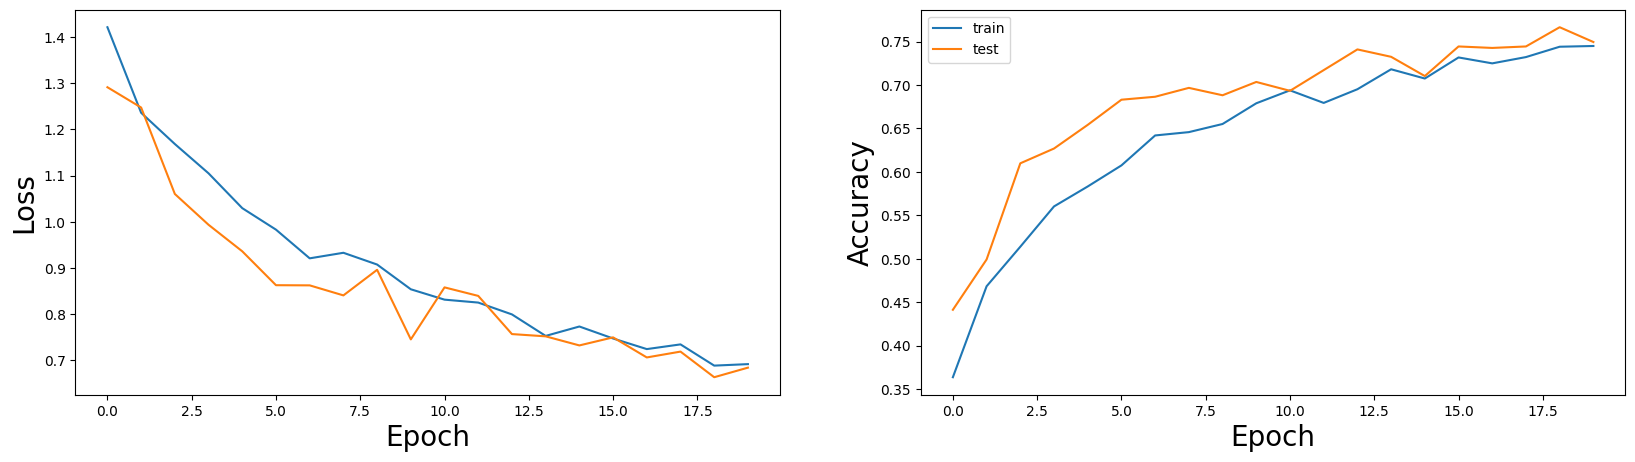

In [28]:
training_loss = df_history['loss']
val_loss = df_history['val_loss']

training_accuracy = df_history['accuracy']
val_accuracy = df_history['val_accuracy']

# plot of the loss
fig, ax = plt.subplots(1, 2, figsize = (20, 5)) # create two axes (0, 1)
ax[0].plot(training_loss)
ax[0].plot(val_loss)
ax[0].set_xlabel('Epoch', fontsize = 20)
ax[0].set_ylabel('Loss', fontsize = 20)
plt.legend(['train', 'test'])

# plot of the accuracy
ax[1].plot(training_accuracy)
ax[1].plot(val_accuracy)
ax[1].set_xlabel('Epoch', fontsize = 20)
ax[1].set_ylabel('Accuracy', fontsize = 20)
plt.legend(['train', 'test'])


In [29]:
# evaluation

model.evaluate(x = x_test, y = y_test_cat)

23/23 [==============================] - 2s 72ms/step - loss: 0.7385 - accuracy: 0.7248


[0.7385351061820984, 0.7247956395149231]

In [30]:
# evaluation on the test set
y_pred = model.predict(x_test)
print(y_pred[:5])
y_pred_class = np.argmax(y_pred, axis=1)

23/23 [==============================] - 2s 79ms/step
[[9.8806262e-01 4.8815500e-06 1.1322679e-02 5.7963816e-06 6.0405472e-04]
 [7.7187923e-07 2.5550701e-02 1.2274076e-05 9.6652538e-01 7.9109333e-03]
 [4.4366200e-02 1.4655103e-01 3.5232637e-02 4.2799881e-01 3.4585136e-01]
 [2.0667113e-01 5.6689626e-01 1.3465539e-01 7.7856295e-03 8.3991610e-02]
 [3.1281002e-02 8.7689149e-01 5.5719517e-02 2.3267162e-03 3.3781249e-02]]


In [66]:
y_test_class = np.argmax(y_test)

In [72]:
label_encoder = LabelEncoder()
y_test_class = label_encoder.fit_transform(y_test)
#y_test_class = label_encoder.inverse_transform(y_test)

In [43]:
display_labels = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
numerical_labels = [i for i in range(5)]
print (display_labels)
print(numerical_labels)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
[0, 1, 2, 3, 4]


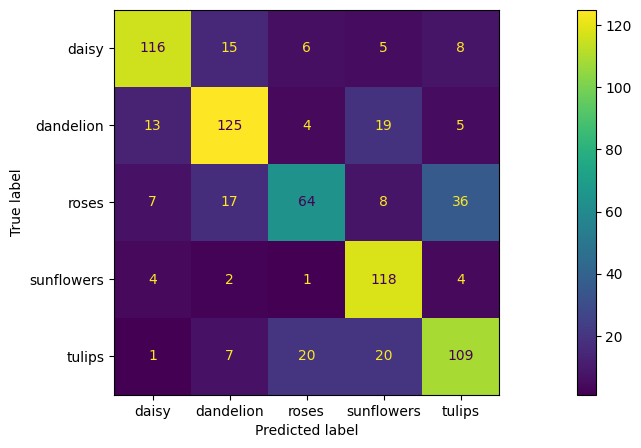

In [91]:
# Create the confusion matrix
con_mat = confusion_matrix(y_test_class, y_pred_class, labels = numerical_labels)
plt.figure(figsize = (20, 5))
ax = plt.axes()
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = con_mat, display_labels = display_labels)
disp.plot(ax = ax)
plt.show()

In [125]:
# Display the classification reportabs
print(classification_report(y_test_class, y_pred_class))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       150
           1       0.36      0.96      0.52       166
           2       0.33      0.01      0.01       132
           3       0.33      0.20      0.25       129
           4       0.51      0.66      0.58       157

    accuracy                           0.40       734
   macro avg       0.31      0.37      0.27       734
weighted avg       0.31      0.40      0.29       734



#### Use the kernel_size = (5, 5) in the first layer instead of (3, 3)

In [116]:
# CNN Model

width_npix = 180
height_npix = 180

model = Sequential()

# 1st layer
model.add(Conv2D(filters = 32, kernel_size = (5, 5), input_shape = (width_npix, height_npix, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd layer
model.add(Conv2D(filters = 64, kernel_size = (3, 3), input_shape = (width_npix, height_npix, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

# 3rd layer
model.add(Conv2D(filters = 128, kernel_size = (3, 3), input_shape = (width_npix, height_npix, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

# Flatten layer
model.add(Flatten())

# Dense layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# output layer
model.add(Dense(5, activation = 'softmax'))

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 176, 176, 32)      2432      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 88, 88, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 20, 20, 128)     

In [117]:
# compile the model

adam = Adam(learning_rate = 0.01)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [118]:
# train the model

batch_size = 32
history = model.fit(
    train_datagen.flow(x_train, y_train_cat, batch_size = batch_size, subset = 'training'), 
    epochs = 20, 
    validation_data = train_datagen.flow(x_train, y_train_cat, batch_size = batch_size, subset = 'validation'))

Epoch 1/20
74/74 [==============================] - 32s 430ms/step - loss: 164.5864 - accuracy: 0.2461 - val_loss: 1.5457 - val_accuracy: 0.3458
Epoch 2/20
74/74 [==============================] - 33s 449ms/step - loss: 1.6166 - accuracy: 0.2610 - val_loss: 1.5851 - val_accuracy: 0.2794
Epoch 3/20
74/74 [==============================] - 33s 447ms/step - loss: 1.5898 - accuracy: 0.2627 - val_loss: 1.5702 - val_accuracy: 0.2998
Epoch 4/20
74/74 [==============================] - 33s 444ms/step - loss: 1.5762 - accuracy: 0.2699 - val_loss: 1.5558 - val_accuracy: 0.3169
Epoch 5/20
74/74 [==============================] - 33s 442ms/step - loss: 1.5742 - accuracy: 0.2831 - val_loss: 1.5535 - val_accuracy: 0.3220
Epoch 6/20
74/74 [==============================] - 33s 440ms/step - loss: 1.5582 - accuracy: 0.2920 - val_loss: 1.5872 - val_accuracy: 0.3475
Epoch 7/20
74/74 [==============================] - 33s 440ms/step - loss: 1.5598 - accuracy: 0.2937 - val_loss: 1.5571 - val_accuracy: 0.32

In [119]:
# Plotting the history of the training and evaluation on the validation set

df_history = pd.DataFrame(history.history)
df_history

,loss,accuracy,val_loss,val_accuracy
0,164.586395,0.246062,1.545678,0.345826
1,1.616632,0.260962,1.585136,0.279387
2,1.589825,0.262665,1.570240,0.299830
3,1.576193,0.269902,1.555836,0.316865
4,1.574173,0.283099,1.553517,0.321976
5,1.558239,0.292039,1.587250,0.347530
6,1.559837,0.293742,1.557052,0.327087
7,1.546749,0.292039,1.542264,0.318569
8,1.550020,0.292891,1.533211,0.342419
9,1.512859,0.318859,1.527750,0.344123


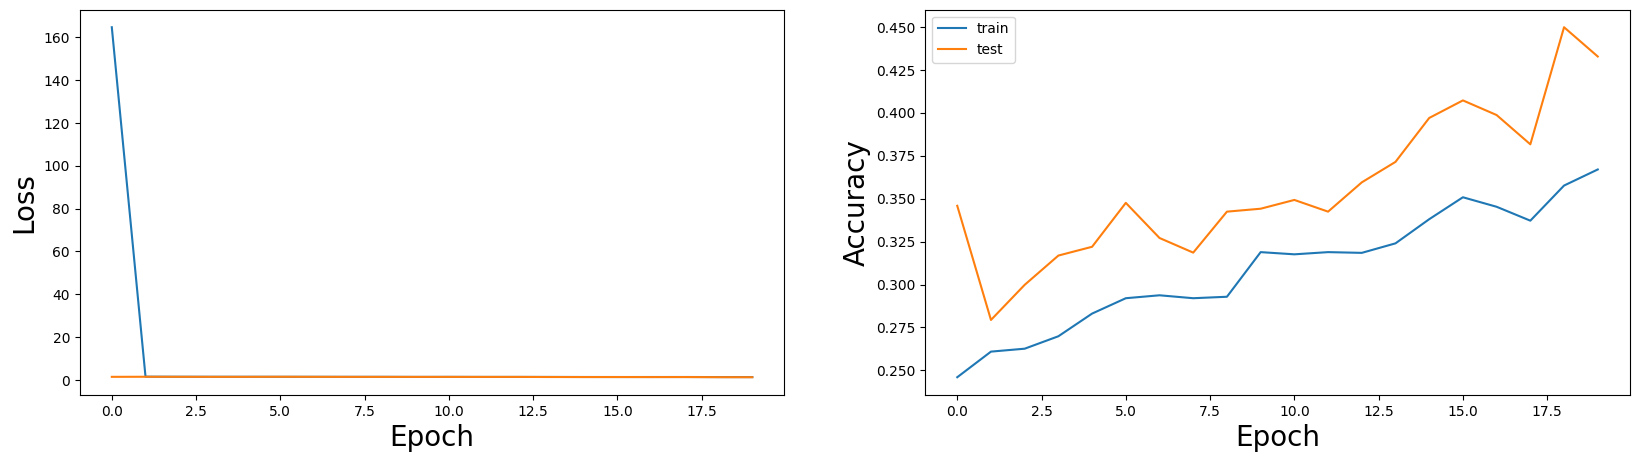

In [120]:
training_loss = df_history['loss']
val_loss = df_history['val_loss']

training_accuracy = df_history['accuracy']
val_accuracy = df_history['val_accuracy']

# plot of the loss
fig, ax = plt.subplots(1, 2, figsize = (20, 5)) # create two axes (0, 1)
ax[0].plot(training_loss)
ax[0].plot(val_loss)
ax[0].set_xlabel('Epoch', fontsize = 20)
ax[0].set_ylabel('Loss', fontsize = 20)
plt.legend(['train', 'test'])

# plot of the accuracy
ax[1].plot(training_accuracy)
ax[1].plot(val_accuracy)
ax[1].set_xlabel('Epoch', fontsize = 20)
ax[1].set_ylabel('Accuracy', fontsize = 20)
plt.legend(['train', 'test'])

In [121]:
# evaluation

model.evaluate(x = x_test, y = y_test_cat)

23/23 [==============================] - 2s 72ms/step - loss: 1.3741 - accuracy: 0.3965


[1.374137282371521, 0.3964577615261078]

In [159]:
# evaluation on the test set
y_pred = model.predict(x_test)
print(y_pred[:5])
y_pred_class = np.argmax(y_pred, axis=1)

23/23 [==============================] - 2s 74ms/step
[[0.16392006 0.24549958 0.17992462 0.19382039 0.21683529]
 [0.16392006 0.24549958 0.17992462 0.19382039 0.21683529]
 [0.16392006 0.24549958 0.17992462 0.19382039 0.21683529]
 [0.16392006 0.24549958 0.17992462 0.19382039 0.21683529]
 [0.16392006 0.24549958 0.17992462 0.19382039 0.21683529]]


In [160]:
y_test_class = np.argmax(y_test)

In [161]:
label_encoder = LabelEncoder()
y_test_class = label_encoder.fit_transform(y_test)
#y_test_class = label_encoder.inverse_transform(y_test)

In [162]:
display_labels = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
numerical_labels = [i for i in range(5)]
print (display_labels)
print(numerical_labels)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
[0, 1, 2, 3, 4]


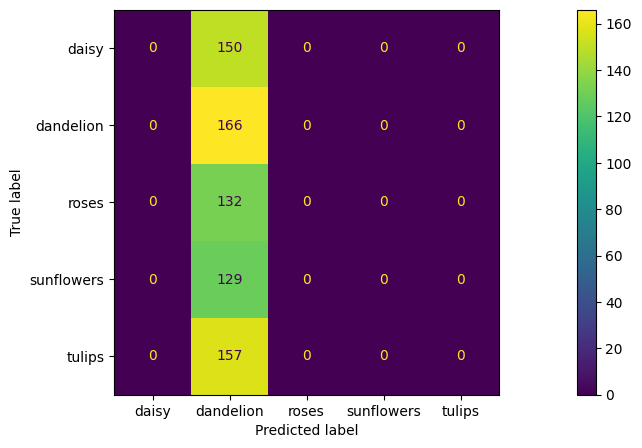

In [163]:
# Create the confusion matrix
con_mat = confusion_matrix(y_test_class, y_pred_class, labels = numerical_labels)
plt.figure(figsize = (20, 5))
ax = plt.axes()
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = con_mat, display_labels = display_labels)
disp.plot(ax = ax)
plt.show()

In [164]:
# Display the classification reportabs
print(classification_report(y_test_class, y_pred_class))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       150
           1       0.23      1.00      0.37       166
           2       0.00      0.00      0.00       132
           3       0.00      0.00      0.00       129
           4       0.00      0.00      0.00       157

    accuracy                           0.23       734
   macro avg       0.05      0.20      0.07       734
weighted avg       0.05      0.23      0.08       734



#### Add another Conv Layer

In [128]:
# CNN Model

width_npix = 180
height_npix = 180

model = Sequential()

# 1st layer
model.add(Conv2D(filters = 32, kernel_size = (3, 3), input_shape = (width_npix, height_npix, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd layer
model.add(Conv2D(filters = 64, kernel_size = (3, 3), input_shape = (width_npix, height_npix, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

# 3rd layer
model.add(Conv2D(filters = 128, kernel_size = (3, 3), input_shape = (width_npix, height_npix, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))


# 4th layer
model.add(Conv2D(filters = 128, kernel_size = (3, 3), input_shape = (width_npix, height_npix, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))


# Flatten layer
model.add(Flatten())

# Dense layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# output layer
model.add(Dense(5, activation = 'softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 20, 20, 128)     

In [133]:
# compile the model

adam = Adam(learning_rate = 0.01)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [130]:
# train the model

batch_size = 32
history = model.fit(
    train_datagen.flow(x_train, y_train_cat, batch_size = batch_size, subset = 'training'), 
    epochs = 20, 
    validation_data = train_datagen.flow(x_train, y_train_cat, batch_size = batch_size, subset = 'validation'))

Epoch 1/20
74/74 [==============================] - 32s 419ms/step - loss: 134.0860 - accuracy: 0.2265 - val_loss: 1.5936 - val_accuracy: 0.2709
Epoch 2/20
74/74 [==============================] - 31s 417ms/step - loss: 1.6039 - accuracy: 0.2469 - val_loss: 1.5799 - val_accuracy: 0.2811
Epoch 3/20
74/74 [==============================] - 32s 434ms/step - loss: 1.5994 - accuracy: 0.2584 - val_loss: 1.5940 - val_accuracy: 0.2658
Epoch 4/20
74/74 [==============================] - 31s 424ms/step - loss: 1.6006 - accuracy: 0.2465 - val_loss: 1.5999 - val_accuracy: 0.2641
Epoch 5/20
74/74 [==============================] - 29s 396ms/step - loss: 1.6050 - accuracy: 0.2452 - val_loss: 1.5948 - val_accuracy: 0.2658
Epoch 6/20
74/74 [==============================] - 29s 396ms/step - loss: 1.6001 - accuracy: 0.2452 - val_loss: 1.5948 - val_accuracy: 0.2658
Epoch 7/20
74/74 [==============================] - 30s 400ms/step - loss: 1.5999 - accuracy: 0.2452 - val_loss: 1.5937 - val_accuracy: 0.26

In [165]:
# Plotting the history of the training and evaluation on the validation set

df_history = pd.DataFrame(history.history)
df_history

,loss,accuracy,val_loss,val_accuracy
0,134.085983,0.226479,1.593612,0.270869
1,1.603941,0.246914,1.579851,0.281090
2,1.599401,0.258408,1.593979,0.265758
3,1.600585,0.246488,1.599936,0.264055
4,1.605031,0.245211,1.594810,0.265758
5,1.600055,0.245211,1.594849,0.265758
6,1.599861,0.245211,1.593659,0.265758
7,1.599655,0.245211,1.594053,0.265758
8,1.599778,0.245211,1.594660,0.265758
9,1.599948,0.245211,1.594265,0.265758


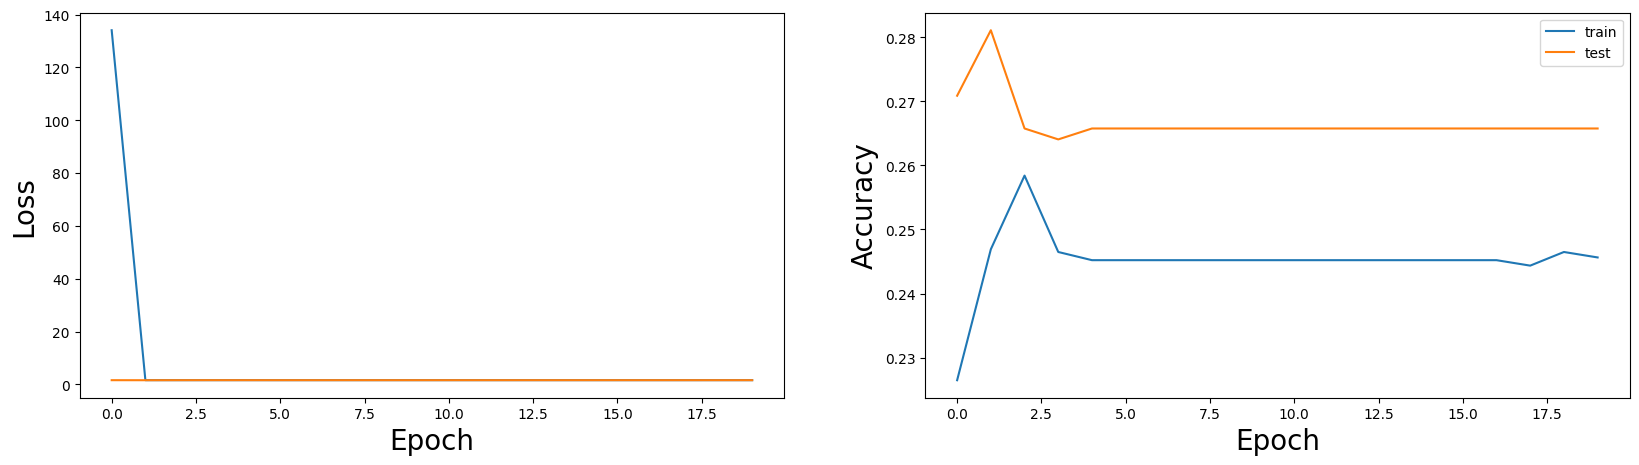

In [166]:
training_loss = df_history['loss']
val_loss = df_history['val_loss']

training_accuracy = df_history['accuracy']
val_accuracy = df_history['val_accuracy']

# plot of the loss
fig, ax = plt.subplots(1, 2, figsize = (20, 5)) # create two axes (0, 1)
ax[0].plot(training_loss)
ax[0].plot(val_loss)
ax[0].set_xlabel('Epoch', fontsize = 20)
ax[0].set_ylabel('Loss', fontsize = 20)
plt.legend(['train', 'test'])

# plot of the accuracy
ax[1].plot(training_accuracy)
ax[1].plot(val_accuracy)
ax[1].set_xlabel('Epoch', fontsize = 20)
ax[1].set_ylabel('Accuracy', fontsize = 20)
plt.legend(['train', 'test'])

In [167]:
# evaluation

model.evaluate(x = x_test, y = y_test_cat)

23/23 [==============================] - 2s 77ms/step - loss: 1.6110 - accuracy: 0.2262


[1.6109908819198608, 0.2261580377817154]

In [168]:
# evaluation on the test set
y_pred = model.predict(x_test)
print(y_pred[:5])
y_pred_class = np.argmax(y_pred, axis=1)

23/23 [==============================] - 2s 74ms/step
[[0.16392006 0.24549958 0.17992462 0.19382039 0.21683529]
 [0.16392006 0.24549958 0.17992462 0.19382039 0.21683529]
 [0.16392006 0.24549958 0.17992462 0.19382039 0.21683529]
 [0.16392006 0.24549958 0.17992462 0.19382039 0.21683529]
 [0.16392006 0.24549958 0.17992462 0.19382039 0.21683529]]


In [169]:
y_test_class = np.argmax(y_test)

In [170]:
label_encoder = LabelEncoder()
y_test_class = label_encoder.fit_transform(y_test)
#y_test_class = label_encoder.inverse_transform(y_test)

In [171]:
display_labels = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
numerical_labels = [i for i in range(5)]
print (display_labels)
print(numerical_labels)


['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
[0, 1, 2, 3, 4]


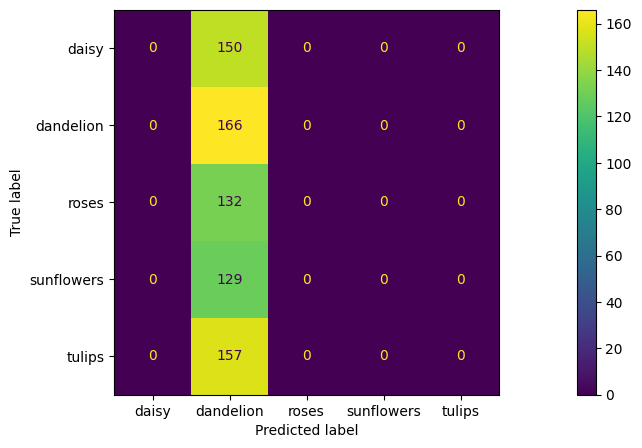

In [172]:
# Create the confusion matrix
con_mat = confusion_matrix(y_test_class, y_pred_class, labels = numerical_labels)
plt.figure(figsize = (20, 5))
ax = plt.axes()
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = con_mat, display_labels = display_labels)
disp.plot(ax = ax)
plt.show()

In [173]:
# Display the classification reportabs
print(classification_report(y_test_class, y_pred_class))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       150
           1       0.23      1.00      0.37       166
           2       0.00      0.00      0.00       132
           3       0.00      0.00      0.00       129
           4       0.00      0.00      0.00       157

    accuracy                           0.23       734
   macro avg       0.05      0.20      0.07       734
weighted avg       0.05      0.23      0.08       734



#### Add strides = (2, 2)

In [174]:
# CNN Model

width_npix = 180
height_npix = 180

model = Sequential()

# 1st layer
model.add(Conv2D(filters = 32, kernel_size = (3, 3), input_shape = (width_npix, height_npix, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd layer
model.add(Conv2D(filters = 64, kernel_size = (3, 3), input_shape = (width_npix, height_npix, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides=(2, 2)))

# 3rd layer
model.add(Conv2D(filters = 128, kernel_size = (3, 3), input_shape = (width_npix, height_npix, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides=(2, 2)))


# Flatten layer
model.add(Flatten())

# Dense layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# output layer
model.add(Dense(5, activation = 'softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 20, 20, 128)     

In [175]:
# compile the model

adam = Adam(learning_rate = 0.01)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [176]:
# train the model

batch_size = 32
history = model.fit(
    train_datagen.flow(x_train, y_train_cat, batch_size = batch_size, subset = 'training'), 
    epochs = 20, 
    validation_data = train_datagen.flow(x_train, y_train_cat, batch_size = batch_size, subset = 'validation'))

Epoch 1/20
74/74 [==============================] - 30s 401ms/step - loss: 78.2692 - accuracy: 0.2848 - val_loss: 1.5538 - val_accuracy: 0.3475
Epoch 2/20
74/74 [==============================] - 29s 394ms/step - loss: 1.5263 - accuracy: 0.3180 - val_loss: 1.5050 - val_accuracy: 0.3543
Epoch 3/20
74/74 [==============================] - 29s 388ms/step - loss: 1.4712 - accuracy: 0.3482 - val_loss: 1.4179 - val_accuracy: 0.3969
Epoch 4/20
74/74 [==============================] - 28s 380ms/step - loss: 1.4292 - accuracy: 0.3734 - val_loss: 1.4481 - val_accuracy: 0.4446
Epoch 5/20
74/74 [==============================] - 28s 380ms/step - loss: 1.4045 - accuracy: 0.3934 - val_loss: 1.3714 - val_accuracy: 0.4259
Epoch 6/20
74/74 [==============================] - 28s 379ms/step - loss: 1.3806 - accuracy: 0.4027 - val_loss: 1.4000 - val_accuracy: 0.4344
Epoch 7/20
74/74 [==============================] - 28s 379ms/step - loss: 1.3913 - accuracy: 0.3951 - val_loss: 1.4847 - val_accuracy: 0.463

In [177]:
# Plotting the history of the training and evaluation on the validation set

df_history = pd.DataFrame(history.history)
df_history

,loss,accuracy,val_loss,val_accuracy
0,78.269249,0.284802,1.553795,0.347530
1,1.526256,0.318008,1.505000,0.354344
2,1.471238,0.348233,1.417901,0.396934
3,1.429237,0.373350,1.448057,0.444634
4,1.404531,0.393359,1.371415,0.425894
5,1.380607,0.402725,1.399954,0.434412
6,1.391308,0.395062,1.484655,0.463373
7,1.398591,0.394636,1.440320,0.419080
8,1.389182,0.395913,1.403818,0.412266
9,1.402244,0.379736,1.519119,0.432709


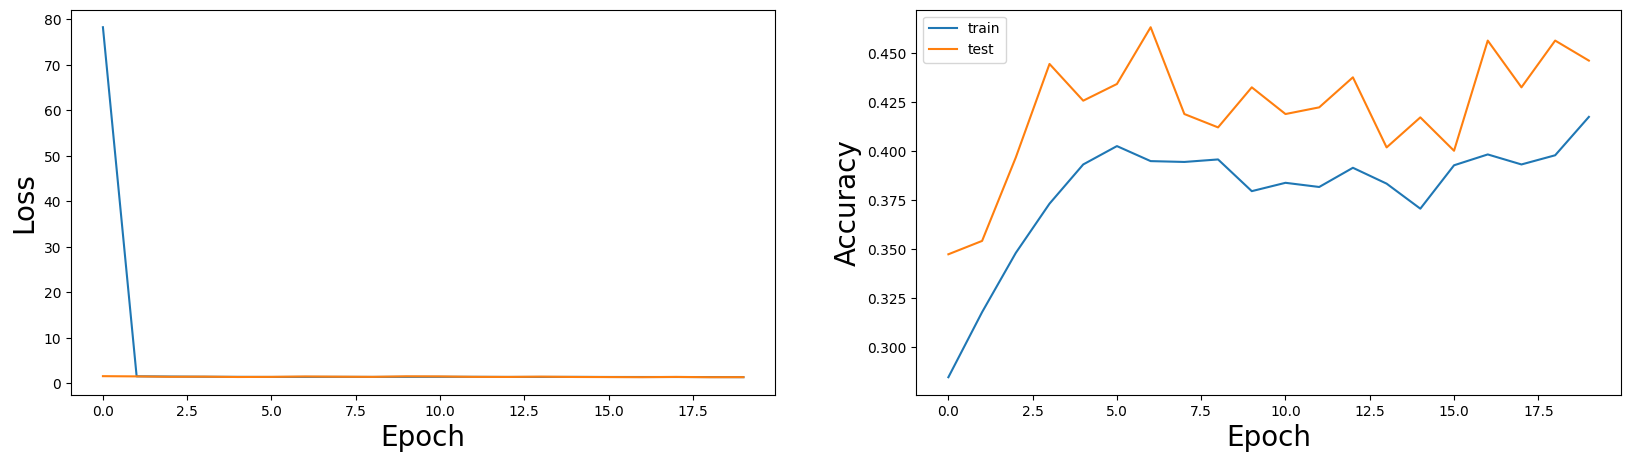

In [178]:
training_loss = df_history['loss']
val_loss = df_history['val_loss']

training_accuracy = df_history['accuracy']
val_accuracy = df_history['val_accuracy']

# plot of the loss
fig, ax = plt.subplots(1, 2, figsize = (20, 5)) # create two axes (0, 1)
ax[0].plot(training_loss)
ax[0].plot(val_loss)
ax[0].set_xlabel('Epoch', fontsize = 20)
ax[0].set_ylabel('Loss', fontsize = 20)
plt.legend(['train', 'test'])

# plot of the accuracy
ax[1].plot(training_accuracy)
ax[1].plot(val_accuracy)
ax[1].set_xlabel('Epoch', fontsize = 20)
ax[1].set_ylabel('Accuracy', fontsize = 20)
plt.legend(['train', 'test'])

In [179]:
# evaluation

model.evaluate(x = x_test, y = y_test_cat)

23/23 [==============================] - 2s 69ms/step - loss: 1.3253 - accuracy: 0.3937


[1.3252781629562378, 0.3937329649925232]

In [180]:
# evaluation on the test set
y_pred = model.predict(x_test)
print(y_pred[:5])
y_pred_class = np.argmax(y_pred, axis=1)

23/23 [==============================] - 2s 72ms/step
[[0.19103268 0.29096165 0.13226125 0.267515   0.11822946]
 [0.1930263  0.31304774 0.1164741  0.26380804 0.11364387]
 [0.16254358 0.25694317 0.15787707 0.27365622 0.14898   ]
 [0.23549184 0.3653816  0.08377197 0.22907797 0.08627666]
 [0.23390725 0.4039762  0.07443882 0.21206142 0.07561626]]


In [181]:
y_test_class = np.argmax(y_test)

In [182]:
label_encoder = LabelEncoder()
y_test_class = label_encoder.fit_transform(y_test)
#y_test_class = label_encoder.inverse_transform(y_test)

In [183]:
display_labels = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
numerical_labels = [i for i in range(5)]
print (display_labels)
print(numerical_labels)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
[0, 1, 2, 3, 4]


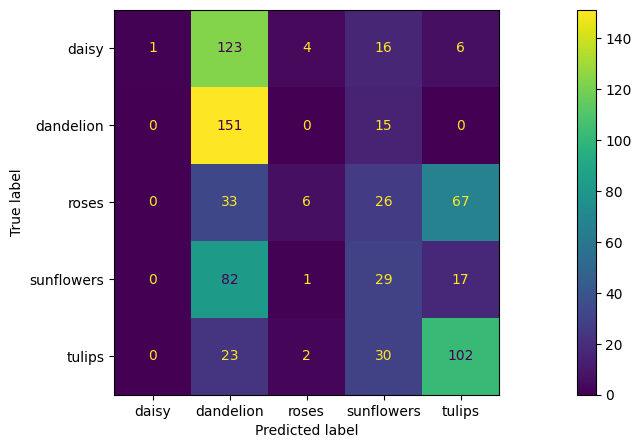

In [184]:
# Create the confusion matrix
con_mat = confusion_matrix(y_test_class, y_pred_class, labels = numerical_labels)
plt.figure(figsize = (20, 5))
ax = plt.axes()
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = con_mat, display_labels = display_labels)
disp.plot(ax = ax)
plt.show()

In [186]:
# Display the classification reportabs
print(classification_report(y_test_class, y_pred_class))

              precision    recall  f1-score   support

           0       1.00      0.01      0.01       150
           1       0.37      0.91      0.52       166
           2       0.46      0.05      0.08       132
           3       0.25      0.22      0.24       129
           4       0.53      0.65      0.58       157

    accuracy                           0.39       734
   macro avg       0.52      0.37      0.29       734
weighted avg       0.53      0.39      0.30       734



#### Add strides = (2, 2) + kernel_size = (5,5) in the first layer + Learning Rate = 0.001

In [190]:
# CNN Model

width_npix = 180
height_npix = 180

model = Sequential()

# 1st layer
model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'Same', input_shape = (width_npix, height_npix, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd layer
model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'Same', input_shape = (width_npix, height_npix, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides=(2,2)))

# 3rd layer
model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'Same', input_shape = (width_npix, height_npix, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides=(2,2)))

# Flatten layer
model.add(Flatten())

# Dense layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# output layer
model.add(Dense(5, activation = 'softmax'))

model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 180, 180, 32)      2432      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 45, 45, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 45, 45, 128)       73856     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 22, 22, 128)     

In [191]:
# compile the model

adam = Adam(learning_rate = 0.001)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [192]:
# train the model

batch_size = 32
history = model.fit(
    train_datagen.flow(x_train, y_train_cat, batch_size = batch_size, subset = 'training'), 
    epochs = 20, 
    validation_data = train_datagen.flow(x_train, y_train_cat, batch_size = batch_size, subset = 'validation'))

Epoch 1/20
74/74 [==============================] - 37s 493ms/step - loss: 10.8373 - accuracy: 0.2431 - val_loss: 1.6068 - val_accuracy: 0.2658
Epoch 2/20
74/74 [==============================] - 39s 529ms/step - loss: 1.6062 - accuracy: 0.2452 - val_loss: 1.6033 - val_accuracy: 0.2658
Epoch 3/20
74/74 [==============================] - 37s 503ms/step - loss: 1.6039 - accuracy: 0.2452 - val_loss: 1.6011 - val_accuracy: 0.2658
Epoch 4/20
74/74 [==============================] - 37s 504ms/step - loss: 1.6024 - accuracy: 0.2452 - val_loss: 1.5993 - val_accuracy: 0.2658
Epoch 5/20
74/74 [==============================] - 38s 509ms/step - loss: 1.6013 - accuracy: 0.2452 - val_loss: 1.5977 - val_accuracy: 0.2658
Epoch 6/20
74/74 [==============================] - 38s 509ms/step - loss: 1.6005 - accuracy: 0.2452 - val_loss: 1.5968 - val_accuracy: 0.2658
Epoch 7/20
74/74 [==============================] - 37s 503ms/step - loss: 1.6000 - accuracy: 0.2452 - val_loss: 1.5961 - val_accuracy: 0.265

In [195]:
# Plotting the history of the training and evaluation on the validation set

df_history = pd.DataFrame(history.history)
df_history

,loss,accuracy,val_loss,val_accuracy
0,10.837312,0.243082,1.606814,0.265758
1,1.606211,0.245211,1.603340,0.265758
2,1.603942,0.245211,1.601075,0.265758
3,1.602449,0.245211,1.599279,0.265758
4,1.601262,0.245211,1.597668,0.265758
5,1.600474,0.245211,1.596784,0.265758
6,1.599957,0.245211,1.596148,0.265758
7,1.599558,0.245211,1.595566,0.265758
8,1.599310,0.244785,1.595086,0.265758
9,1.599175,0.245211,1.594849,0.265758


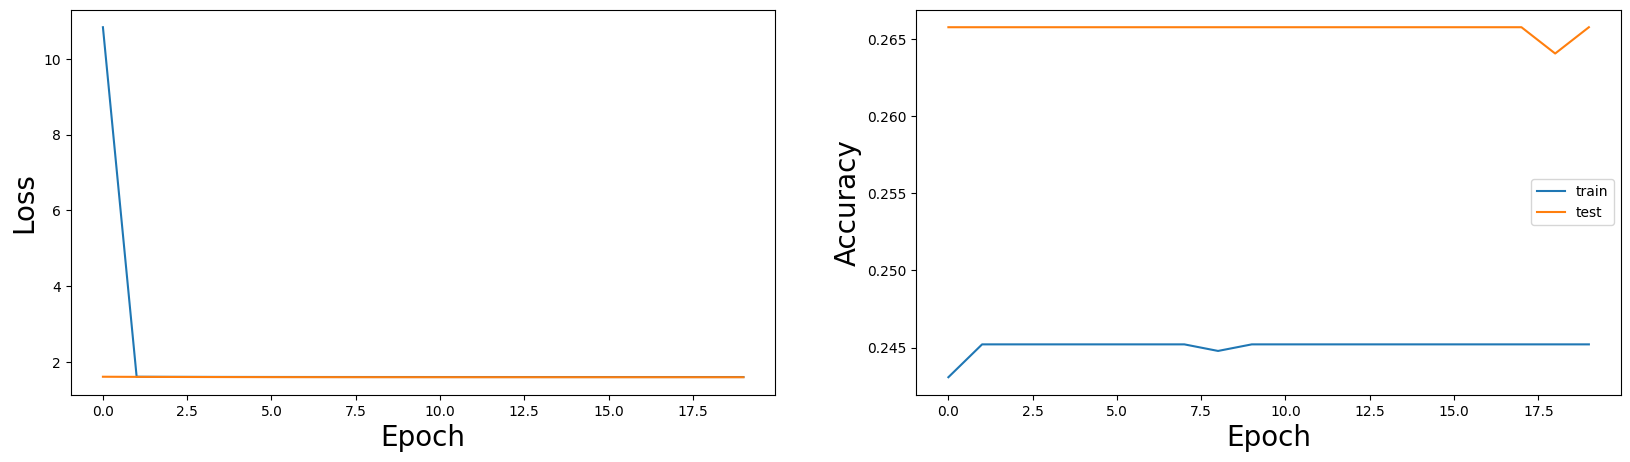

In [196]:
training_loss = df_history['loss']
val_loss = df_history['val_loss']

training_accuracy = df_history['accuracy']
val_accuracy = df_history['val_accuracy']

# plot of the loss
fig, ax = plt.subplots(1, 2, figsize = (20, 5)) # create two axes (0, 1)
ax[0].plot(training_loss)
ax[0].plot(val_loss)
ax[0].set_xlabel('Epoch', fontsize = 20)
ax[0].set_ylabel('Loss', fontsize = 20)
plt.legend(['train', 'test'])

# plot of the accuracy
ax[1].plot(training_accuracy)
ax[1].plot(val_accuracy)
ax[1].set_xlabel('Epoch', fontsize = 20)
ax[1].set_ylabel('Accuracy', fontsize = 20)
plt.legend(['train', 'test'])

In [197]:
# evaluation

model.evaluate(x = x_test, y = y_test_cat)

23/23 [==============================] - 2s 81ms/step - loss: 1.6108 - accuracy: 0.2262


[1.6108025312423706, 0.2261580377817154]

In [198]:
# evaluation on the test set
y_pred = model.predict(x_test)
print(y_pred[:5])
y_pred_class = np.argmax(y_pred, axis=1)

23/23 [==============================] - 2s 82ms/step
[[0.16478004 0.2443237  0.17680155 0.19405824 0.22003649]
 [0.16478004 0.2443237  0.17680155 0.19405824 0.22003649]
 [0.16478004 0.2443237  0.17680155 0.19405824 0.22003649]
 [0.16478004 0.2443237  0.17680155 0.19405824 0.22003649]
 [0.16478004 0.2443237  0.17680155 0.19405824 0.22003649]]


In [199]:
y_test_class = np.argmax(y_test)

In [200]:
label_encoder = LabelEncoder()
y_test_class = label_encoder.fit_transform(y_test)
#y_test_class = label_encoder.inverse_transform(y_test)

In [201]:
display_labels = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
numerical_labels = [i for i in range(5)]
print (display_labels)
print(numerical_labels)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
[0, 1, 2, 3, 4]


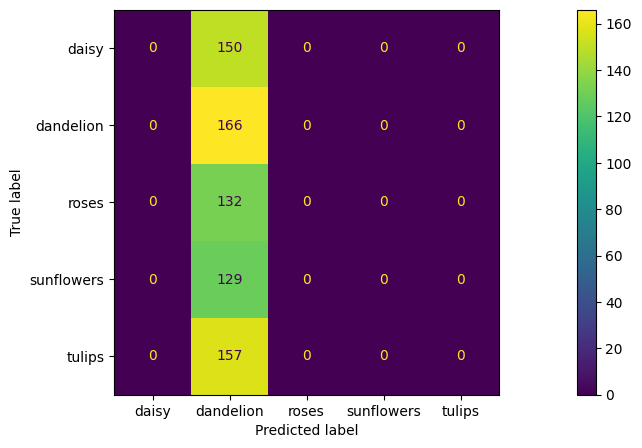

In [202]:
# Create the confusion matrix
con_mat = confusion_matrix(y_test_class, y_pred_class, labels = numerical_labels)
plt.figure(figsize = (20, 5))
ax = plt.axes()
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = con_mat, display_labels = display_labels)
disp.plot(ax = ax)
plt.show()

In [203]:
# Display the classification reportabs
print(classification_report(y_test_class, y_pred_class))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       150
           1       0.23      1.00      0.37       166
           2       0.00      0.00      0.00       132
           3       0.00      0.00      0.00       129
           4       0.00      0.00      0.00       157

    accuracy                           0.23       734
   macro avg       0.05      0.20      0.07       734
weighted avg       0.05      0.23      0.08       734

